In [ ]:
# Random Forest Pipe with best estimators from Grid Search
r_forest_poly_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('classifier', RandomForestClassifier(
                                          max_depth=20, # 20
                                          n_estimators=100,
                                          min_samples_leaf= 5,
                                          min_samples_split=2,
                                          random_state=42)) 
])

r_forest_poly_pipe.fit(X=features_train_resampled, y=target_train_resampled)
target_test_pred = r_forest_poly_pipe.predict(X=features_test_cleaned)
print(classification_report(y_true=target_test, y_pred=target_test_pred))

conf_matrix = confusion_matrix(y_true=target_test, y_pred=target_test_pred)
print("Confusion Matrix:\n", conf_matrix)
roc_auc = roc_auc_score(target_test, r_forest_poly_pipe.predict_proba(features_test_cleaned)[:, 1])
print("\nroc_auc:", roc_auc)

              precision    recall  f1-score   support

           0       0.91      0.90      0.90       809
           1       0.59      0.63      0.61       191

    accuracy                           0.85      1000
   macro avg       0.75      0.76      0.76      1000
weighted avg       0.85      0.85      0.85      1000

Confusion Matrix:
 [[726  83]
 [ 71 120]]

roc_auc: 0.8515004627262668


### Conclusion
- After hyperparameter tuning, the f1-score and other metrics have improved.
- However, the f1-score is slightly lower compared to the model without polynomial features.

It is worth investigating whether reducing the number of features can help mitigate overfitting and improve the f1-score.

In [1]:
# Checking the structure of transformed data
# Creating a list of column names and the corresponding DataFrame

# Transforming training data using the preprocessor  
transformed_features_train = preprocessor.fit_transform(features_train_resampled)  

# Transforming test data using the same preprocessor  
transformed_features_test = preprocessor.transform(features_test_cleaned)  

# Extracting feature names after transformation:  
# 1. Extracting OneHotEncoded column names from "Geography"  
geography_columns = preprocessor.transformers_[0][1].named_steps['ohe'].get_feature_names_out(input_features=['Geography'])  

# 2. Extracting polynomial feature names  
polynomial_transformer = preprocessor.transformers_[3][1].named_steps['poly']  
poly_columns = polynomial_transformer.get_feature_names_out(input_features=polynomial_columns)  

# Combining all feature names in the correct order  
all_transformed_columns = list(geography_columns) + numerical_columns + boolean_columns + list(poly_columns)  

# Creating a DataFrame with transformed training data  
transformed_train_df = pd.DataFrame(transformed_features_train, columns=all_transformed_columns)  

# Creating a DataFrame with transformed test data  
transformed_test_df = pd.DataFrame(transformed_features_test, columns=all_transformed_columns)  

# Displaying the transformed test data  
display(transformed_test_df)  


NameError: name 'preprocessor' is not defined

In [ ]:
# Extracting the RandomForestClassifier model from the pipeline
rf_poly_model = r_forest_poly_pipe.named_steps['classifier']

# Retrieving feature importance scores from the model
importances = rf_poly_model.feature_importances_

# Combining feature names with their respective importance scores
feature_importances_with_names = list(zip(all_transformed_columns, importances))

# Sorting features by importance in descending order
sorted_feature_importances = sorted(feature_importances_with_names, key=lambda x: x[1], reverse=True)

# Displaying sorted features along with their importance scores as percentages
print("Feature Importances:")
for feature, importance in sorted_feature_importances:
    importance_percent = round(importance * 100, 2)  # Convert to percentage
    print(f"{feature}: {importance_percent}%")



Feature Importances:
Age: 17.71%
NumOfProducts: 12.56%
Age Balance: 8.05%
Balance: 5.76%
Balance^2: 4.72%
Age EstimatedSalary: 4.25%
Balance EstimatedSalary: 4.08%
Age CreditScore: 4.06%
EstimatedSalary^2: 3.99%
EstimatedSalary CreditScore: 3.96%
Balance CreditScore: 3.92%
EstimatedSalary: 3.84%
Age^2: 3.82%
CreditScore: 3.78%
CreditScore^2: 3.7%
IsActiveMember: 3.39%
Tenure: 2.49%
Geography_Germany: 2.29%
Gender: 1.5%
Geography_France: 0.91%
Geography_Spain: 0.68%
HasCrCard: 0.57%


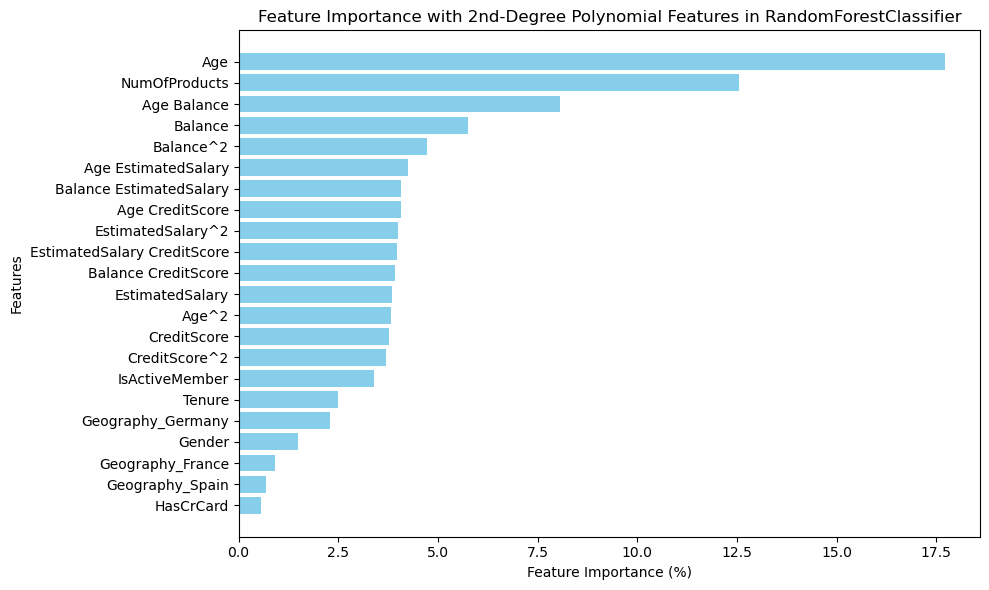

In [ ]:
# Extracting feature names and their importance scores from the sorted list
features, importances = zip(*sorted_feature_importances)

# Converting importance scores to percentages
importances_percent = [round(imp * 100, 2) for imp in importances]

# Visualization
plt.figure(figsize=(10, 6))
plt.barh(features, importances_percent, color='skyblue')
plt.xlabel("Feature Importance (%)")
plt.ylabel("Features")
plt.title("Feature Importance with 2nd-Degree Polynomial Features in RandomForestClassifier")
plt.gca().invert_yaxis()  # Invert Y-axis so the most important features appear at the top
plt.tight_layout()
plt.show()


In [ ]:
# Reducing number of features with importance below 2%

columns_to_keep = [
'Age',
'NumOfProducts',
'Age Balance',
'Balance',
'Balance EstimatedSalary',
'Age EstimatedSalary',
'Balance^2',
'Age CreditScore',
'EstimatedSalary^2',
'Balance CreditScore',
'EstimatedSalary CreditScore',
'EstimatedSalary',
'CreditScore^2',
'CreditScore',
'Age^2',
'Tenure',
'IsActiveMember',
'Geography_Germany',
#'Gender',
#'Geography_France',
#'HasCrCard',
#'Geography_Spain',
]

transformed_reduced_poly_features_test = transformed_test_df[columns_to_keep]
transformed_reduced_poly_features_train = transformed_train_df[columns_to_keep]

In [ ]:
display(transformed_reduced_poly_features_train)

,Age,NumOfProducts,Age Balance,Balance,Balance EstimatedSalary,Age EstimatedSalary,Balance^2,Age CreditScore,EstimatedSalary^2,Balance CreditScore,EstimatedSalary CreditScore,EstimatedSalary,CreditScore^2,CreditScore,Age^2,Tenure,IsActiveMember,Geography_Germany
0,-0.015413,-0.761135,-0.002619,0.169899,-0.213351,0.019355,0.028866,0.007033,1.576920,-0.077522,0.572982,-1.255755,0.208196,-0.456285,0.000238,0.009318,1.0,0.0
1,1.115015,-0.761135,0.600897,0.538914,-0.460176,-0.952105,0.290428,1.163015,0.729136,0.562114,-0.890654,-0.853894,1.087951,1.043049,1.243257,1.042847,1.0,0.0
2,-0.298020,0.743676,0.394765,-1.324627,0.486781,0.109518,1.754636,0.245410,0.135045,1.090789,0.302613,-0.367485,0.678101,-0.823469,0.088816,1.042847,0.0,0.0
3,1.209217,-0.761135,1.774191,1.467224,1.686099,1.389603,2.152745,0.743266,1.320606,0.901855,0.706362,1.149176,0.377816,0.614668,1.462205,0.353828,1.0,0.0
4,1.209217,-0.761135,-1.601761,-1.324627,0.555674,-0.507260,1.754636,-2.944441,0.175976,3.225463,1.021469,-0.419495,5.929216,-2.434998,1.462205,1.387357,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14303,0.644003,-0.761135,0.273673,0.424956,0.021496,0.032576,0.180588,-0.103361,0.002559,-0.068205,-0.008118,0.050583,0.025760,-0.160498,0.414740,-1.024210,1.0,1.0
14304,0.078789,-0.761135,0.031522,0.400078,-0.071079,-0.013998,0.160063,0.024321,0.031564,0.123497,-0.054841,-0.177663,0.095284,0.308681,0.006208,0.698337,1.0,1.0
14305,-0.203817,-0.761135,0.269982,-1.324627,-1.379421,-0.212249,1.754636,0.508768,1.084444,3.306527,-2.599454,1.041366,6.230992,-2.496196,0.041542,1.731866,0.0,0.0
14306,-0.392222,-0.761135,-0.438706,1.118514,-1.555936,0.545610,1.251074,-0.213083,1.935087,0.607656,-0.755730,-1.391074,0.295143,0.543271,0.153838,-1.368720,0.0,0.0


In [ ]:
# Defining the search space for hyperparameter tuning  
search_space_rf = {  
    'n_estimators': np.round(np.geomspace(10, 100, num=6)).astype(int),  # Number of trees
    'max_depth': np.round(np.geomspace(3, 50, num=10)).astype(int),# Maximum depth of each tree
    'min_samples_leaf': [5, 10, 20]  # Minimum number of samples per leaf
}  

# Grid search with cross-validation and parallel computation  
rf_poly_reduced_grid_search = GridSearchCV(  
    estimator=RandomForestClassifier(random_state=42),  
    param_grid=search_space_rf,  
    scoring='f1',  # Optimizing for f1-score  
    cv=5,  # 5-fold cross-validation  
    n_jobs=-1,  # Utilize all available CPU cores  
    verbose=1  # Display progress during training  
)  

# Fitting the model using resampled training data  
rf_poly_reduced_grid_search.fit(transformed_reduced_poly_features_train, target_train_resampled)  
display(rf_poly_reduced_grid_search)  

# Printing the best model and its score  
print("Best Model:\n", rf_poly_reduced_grid_search.best_estimator_)  
print("\nBest f1 Score:", rf_poly_reduced_grid_search.best_score_)  
print("\nBest Parameters:\n", rf_poly_reduced_grid_search.best_estimator_.get_params())  


Fitting 5 folds for each of 180 candidates, totalling 900 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': array([ 3,  4,  6,  8, 10, 14, 20, 27, 37, 50]),
                         'min_samples_leaf': [5, 10, 20],
                         'n_estimators': array([ 10,  16,  25,  40,  63, 100])},
             scoring='f1', verbose=1)

Best Model:
 RandomForestClassifier(max_depth=np.int64(37), min_samples_leaf=5,
                       n_estimators=np.int64(63), random_state=42)

Best f1 Score: 0.9190168321406288

Best Parameters:
 {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': np.int64(37), 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': np.int64(63), 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [ ]:
# Creating a pipeline for the model with the best hyperparameters
rf_poly_reduced_pipe = Pipeline(steps=[    ('classifier', RandomForestClassifier(random_state=42,
                                                                          max_depth=37,
                                                                          n_estimators=63,
                                                                          min_samples_leaf= 5,
                                                                          min_samples_split=2,
                                                                          ))])
# evaluation of prediction
rf_poly_reduced_pipe.fit(X=transformed_reduced_poly_features_train, y=target_train_resampled)
target_test_pred = rf_poly_reduced_pipe.predict(X=transformed_reduced_poly_features_test)
print(classification_report(y_true=target_test, y_pred=target_test_pred))

conf_matrix = confusion_matrix(y_true=target_test, y_pred=target_test_pred)
print("Confusion Matrix:\n", conf_matrix)
roc_auc = roc_auc_score(target_test, rf_poly_reduced_pipe.predict_proba(transformed_reduced_poly_features_test)[:, 1]) 
print("\nroc_auc:", roc_auc)

              precision    recall  f1-score   support

           0       0.90      0.89      0.89       809
           1       0.55      0.56      0.56       191

    accuracy                           0.83      1000
   macro avg       0.73      0.73      0.73      1000
weighted avg       0.83      0.83      0.83      1000

Confusion Matrix:
 [[723  86]
 [ 84 107]]

roc_auc: 0.8425112769303452


In [ ]:
# Creating a pipeline for the model with the best hyperparameters
rf_poly_reduced_pipe = Pipeline(steps=[    ('classifier', RandomForestClassifier(random_state=42,
                                                                          max_depth=37,
                                                                          n_estimators=63,
                                                                          min_samples_leaf= 5,
                                                                          min_samples_split=2,
                                                                          ))])
# evaluation of prediction
rf_poly_reduced_pipe.fit(X=transformed_reduced_poly_features_train, y=target_train_resampled)
target_test_pred = rf_poly_reduced_pipe.predict(X=transformed_reduced_poly_features_test)
print(classification_report(y_true=target_test, y_pred=target_test_pred))

conf_matrix = confusion_matrix(y_true=target_test, y_pred=target_test_pred)
print("Confusion Matrix:\n", conf_matrix)
roc_auc = roc_auc_score(target_test, rf_poly_reduced_pipe.predict_proba(transformed_reduced_poly_features_test)[:, 1]) 
print("\nroc_auc:", roc_auc)

              precision    recall  f1-score   support

           0       0.90      0.89      0.89       809
           1       0.55      0.56      0.56       191

    accuracy                           0.83      1000
   macro avg       0.73      0.73      0.73      1000
weighted avg       0.83      0.83      0.83      1000

Confusion Matrix:
 [[723  86]
 [ 84 107]]

roc_auc: 0.8425112769303452
